In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, drag_coeff=0.3):
    g = 9.81
    rho = 1.225

    mass = 10.0
    wing_area = 1.2
    CL = 0.8
    CD = drag_coeff
    stall_speed = 8.0
    eta = 0.7 # Efficiency of the propulsion system

    dt = 0.1
    T_end = 50.0
    time = np.arange(0, T_end, dt)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    x = np.zeros_like(time)

    horizontal_thrust = np.clip(np.linspace(0, horizontal_thrust_max, len(time)), 0, horizontal_thrust_max)
    vertical_thrust = np.clip(np.linspace(vertical_thrust_start, 0, len(time)), 0, vertical_thrust_start)
    
    energy_vertical = 0.0
    energy_horizontal = 0.0
    
    for i in range(1, len(time)):
        speed = np.sqrt(vx[i-1]**2 + vz[i-1]**2)
        lift = 0.5 * rho * vx[i-1]**2 * wing_area * CL
        drag = 0.5 * rho * vx[i-1]**2 * wing_area * CD

        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]

        Fz = Tv - mass * g + lift * np.cos(pitch[i])
        Fy = Th * np.sin(pitch[i])
        az = (Fz + Fy) / mass
        vz[i] = vz[i-1] + az * dt
        alt[i] = alt[i-1] + vz[i] * dt

        ax = (Th * np.cos(pitch[i]) + lift * np.sin(pitch[i]) - drag) / mass
        vx[i] = vx[i-1] + ax * dt
        x[i] = x[i-1] + vx[i] * dt
        
     # Energy Estimation
        # Estimate induced velocity for vertical thrust
        rotor_area = 0.2  # m² (adjust based on your prop setup)
        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            # print(f"Induced Velocity: {v_induced:.2f} m/s")
            P_vert = (Tv * v_induced) / eta
        else:
            # print("No vertical thrust applied, no induced velocity.")
            P_vert = 0
        v_eff_horizontal = abs(vx[i])
        P_horiz = (Th * v_eff_horizontal) / eta
        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, alt, label="Altitude (m)")
    plt.ylabel("Altitude (m)")
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(time, vx, label="Horizontal Velocity (m/s)")
    plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
    plt.ylabel("Vx (m/s)")
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
    plt.ylabel("Pitch Angle (deg)")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
    E_total = energy_vertical + energy_horizontal
    print(f"🔋 Estimated Energy Consumption:")
    print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
    print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
    print(f" - Total Energy: {E_total / 1000:.2f} kJ")
interact(simulate_transition,
         horizontal_thrust_max=FloatSlider(value=20, min=10, max=50, step=1, description='Max H-Thrust (N)'),
         vertical_thrust_start=FloatSlider(value=81200, min=80, max=160, step=1, description='Start V-Thrust (N)'),
         max_pitch_deg=FloatSlider(value=20, min=5, max=45, step=1, description='Max Pitch (deg)'),
         drag_coeff=FloatSlider(value=0.3, min=0.05, max=1.0, step=0.05, description='Drag Coeff (CD)'))


interactive(children=(FloatSlider(value=20.0, description='Max H-Thrust (N)', max=50.0, min=10.0, step=1.0), F…

<function __main__.simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, drag_coeff=0.3)>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, T_end=20):
    g = 9.81
    rho = 1.225

    mass = 10.0
    wing_area = 1.5
    # Aerodynamic coefficients (airfoil-based)
    CL0 = 0.2           # Base lift coefficient at 0 AoA
    CL_alpha = 5.7      # Lift curve slope (per radian)
    CD0 = 0.02          # Zero-lift drag coefficient
    k = 0.04            # Induced drag factor
    stall_speed = 8.0

    eta = 0.7 # Efficiency of the propulsion system
    
    z_target = 50  # meters (target cruise altitude)
    Kp_z = 1.5     # proportional gain for altitude control

    dt = 0.1
    T_end = T_end  # seconds
    time = np.arange(0, T_end, dt)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    x = np.zeros_like(time)
    ngsx = np.zeros_like(time)  # g's experienced during maneuver
    ngsy = np.zeros_like(time)  # g's experienced during maneuver

    horizontal_thrust = np.clip(np.linspace(0, horizontal_thrust_max, len(time)), 0, horizontal_thrust_max)
    vertical_thrust = np.clip(np.linspace(vertical_thrust_start, 0, len(time)), 0, vertical_thrust_start)
    
    energy_vertical = 0.0
    energy_horizontal = 0.0
    
    for i in range(1, len(time)):
        # Compute flight path angle
        flight_path_angle = np.arctan2(vz[i-1], vx[i-1] + 1e-4)  # Avoid division by zero
        alpha = pitch[i] - flight_path_angle  # AoA

        # Limit AoA to realistic range (avoid extreme stall in this simple model)
        alpha = np.clip(alpha, np.deg2rad(-5), np.deg2rad(15))

        # Update CL and CD based on AoA
        CL = CL0 + CL_alpha * alpha
        CD = CD0 + k * CL**2
        # print(f"{vx[i-1], vz[i-1], alt[i-1], pitch[i], flight_path_angle, alpha, CL, CD}")
        speed = np.sqrt(vx[i-1]**2 + vz[i-1]**2)
        lift = 0.5 * rho * speed**2 * wing_area * CL
        drag = 0.5 * rho * speed**2 * wing_area * CD
        

        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]
        
        # ngsx[i] = (-1*lift * np.sin(alpha) - drag * np.cos(alpha) + Th) / (mass * g * np.sin(pitch[i]))  # g's experienced
        ngsy[i-1] = (lift * np.cos(alpha) - drag * np.sin(alpha) + Tv ) / (mass * g * np.cos(pitch[i]))  # g's experienced
        if i == 1:
            print(mass * g * np.cos(pitch[i]), lift * np.cos(alpha), drag * np.sin(alpha), Tv)
            print(f"Initial G's: {ngsy[i]:.2f} g's")
        
        Fx = -Tv * np.sin(pitch[i]) + Th * np.cos(pitch[i]) - drag * np.cos(flight_path_angle) + -1*lift * np.sin(flight_path_angle)
        Fz = Th * np.sin(pitch[i]) + Tv * np.cos(pitch[i]) - mass * g + lift * np.cos(flight_path_angle) - drag * np.sin(flight_path_angle)
        az = Fz / mass
        
        
        vz[i] = max(vz[i-1] + az * dt, 0)
        alt[i] = max(alt[i-1] + vz[i] * dt, 0)

        ax = Fx / mass
        vx[i] = vx[i-1] + ax * dt
        x[i] = x[i-1] + vx[i] * dt
        
        max_speed = 18  # m/s, adjust based on your flight model
        vx[i] = np.clip(vx[i], -max_speed, max_speed)
        vz[i] = np.clip(vz[i], -max_speed, max_speed)
        
     # Energy Estimation
        # Estimate induced velocity for vertical thrust
        rotor_area = 0.2  # m² (adjust based on your prop setup)
        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            # print(f"Induced Velocity: {v_induced:.2f} m/s")
            P_vert = (Tv * v_induced) / eta
        else:
            # print("No vertical thrust applied, no induced velocity.")
            P_vert = 0
        v_eff_horizontal = abs(vx[i])
        P_horiz = (Th * v_eff_horizontal) / eta
        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt
    E_total = energy_vertical + energy_horizontal
    P_hover = vertical_thrust_start * np.sqrt(vertical_thrust_start / (2 * rho * rotor_area)) / eta
    print(f"Hover Power: {P_hover:.2f} W")
    print(f"Energy consumption hover: {P_hover * 20 / 1000:.2f} kJ")
    
    
    print(f"🔋 Estimated Energy Consumption:")
    print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
    print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
    print(f" - Total Energy: {E_total / 1000:.2f} kJ")
    
    plt.figure(figsize=(12, 8))

    plt.subplot(5, 1, 1)
    plt.plot(time, alt, label="Altitude (m)")
    plt.ylabel("Altitude (m)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(time, vx, label="Horizontal Velocity (m/s)")
    plt.plot(time, vz, label="Vertical Velocity (m/s)")
    plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
    plt.ylabel("Vx (m/s)")
    plt.grid()
    plt.legend()
    
    

    plt.subplot(5, 1, 3)
    plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
    plt.ylabel("Pitch Angle (deg)")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()
    
    plt.subplot(5, 1, 4)
    plt.plot(time, np.rad2deg(pitch), label='Pitch (deg)')
    plt.plot(time, np.rad2deg(np.array(pitch) - np.arctan2(vz, vx + 1e-6)), label='AoA (deg)')
    plt.title("Pitch and Angle of Attack During Transition")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(5, 1, 5)
    plt.plot(time, ngsy, label="G's Experienced")
    plt.ylabel("G's")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
interact(simulate_transition,
         horizontal_thrust_max=FloatSlider(value=50, min=10, max=100, step=1, description='Max H-Thrust (N)'),
         vertical_thrust_start=FloatSlider(value=120, min=80, max=160, step=1, description='Start V-Thrust (N)'),
         max_pitch_deg=FloatSlider(value=10, min=-5, max=30, step=1, description='Max Pitch (deg)'),
         T_end=FloatSlider(value=20, min=5, max=50, step=0.5, description='Time End (s)'))

interactive(children=(FloatSlider(value=50.0, description='Max H-Thrust (N)', min=10.0, step=1.0), FloatSlider…

<function __main__.simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, T_end=20)>

Attempt to revise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def compute_aero_forces(vx, vz, pitch, CL0, CL_alpha, CD0, k, rho, wing_area):
    flight_path_angle = np.arctan2(vz, vx + 1e-4)
    alpha = pitch - flight_path_angle
    alpha = np.clip(alpha, np.deg2rad(-5), np.deg2rad(15))  # Limit AoA
    CL = CL0 + CL_alpha * alpha
    CD = CD0 + k * CL**2
    speed = np.sqrt(vx**2 + vz**2)
    lift = 0.5 * rho * speed**2 * wing_area * CL
    drag = 0.5 * rho * speed**2 * wing_area * CD
    return lift, drag, alpha, flight_path_angle

def compute_g_load(lift, drag, Tv, pitch, alpha, mass, g):
    numerator = lift * np.cos(alpha) - drag * np.sin(alpha) + Tv
    denominator = mass * g * np.cos(pitch)
    return numerator / denominator

def simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, T_end=20):
    g = 9.81
    rho = 1.225
    mass = 10.0
    wing_area = 1.5

    CL0 = 0.2
    CL_alpha = 5.7
    CD0 = 0.02
    k = 0.04
    stall_speed = 8.0
    eta = 0.7

    dt = 0.1
    time = np.arange(0, T_end, dt)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    x = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    ngsy = np.zeros_like(time)

    horizontal_thrust = np.clip(np.linspace(0, horizontal_thrust_max, len(time)), 0, horizontal_thrust_max)
    vertical_thrust = np.clip(np.linspace(vertical_thrust_start, 0, len(time)), 0, vertical_thrust_start)

    energy_vertical = 0.0
    energy_horizontal = 0.0
    rotor_area = 0.2  # for induced velocity estimate

    for i in range(1, len(time)):
        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]
        pitch_i = pitch[i]

        lift, drag, alpha, gamma = compute_aero_forces(vx[i-1], vz[i-1], pitch_i,
                                                       CL0, CL_alpha, CD0, k, rho, wing_area)

        ngsy[i-1] = compute_g_load(lift, drag, Tv, pitch_i, alpha, mass, g)

        if i == 1:
            print(f"mass * g * cos(pitch): {mass * g * np.cos(pitch_i):.2f}")
            print(f"Lift*cos(alpha): {lift * np.cos(alpha):.2f}, Drag*sin(alpha): {drag * np.sin(alpha):.2f}, Tv: {Tv:.2f}")
            print(f"Initial G's: {ngsy[i-1]:.2f} g's")

        Fx = -Tv * np.sin(pitch_i) + Th * np.cos(pitch_i) - drag * np.cos(gamma) - lift * np.sin(gamma)
        Fz = Th * np.sin(pitch_i) + Tv * np.cos(pitch_i) - mass * g + lift * np.cos(gamma) - drag * np.sin(gamma)

        ax = Fx / mass
        az = Fz / mass

        vx[i] = np.clip(vx[i-1] + ax * dt, -18, 18)
        vz[i] = np.clip(vz[i-1] + az * dt, -18, 18)
        alt[i] = max(alt[i-1] + vz[i] * dt, 0)
        x[i] = x[i-1] + vx[i] * dt

        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            P_vert = (Tv * v_induced) / eta
        else:
            P_vert = 0
        P_horiz = (Th * abs(vx[i])) / eta

        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt

    E_total = energy_vertical + energy_horizontal
    P_hover = vertical_thrust_start * np.sqrt(vertical_thrust_start / (2 * rho * rotor_area)) / eta
    print(f"Hover Power: {P_hover:.2f} W")
    print(f"Energy consumption hover: {P_hover * 20 / 1000:.2f} kJ")
    print(f"🔋 Estimated Energy Consumption:")
    print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
    print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
    print(f" - Total Energy: {E_total / 1000:.2f} kJ")

    plt.figure(figsize=(12, 8))

    plt.subplot(5, 1, 1)
    plt.plot(time, alt, label="Altitude (m)")
    plt.ylabel("Altitude (m)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(time, vx, label="Horizontal Velocity (m/s)")
    plt.plot(time, vz, label="Vertical Velocity (m/s)")
    plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
    plt.ylabel("Vx / Vz (m/s)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
    plt.ylabel("Pitch Angle (deg)")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 4)
    aoa = np.rad2deg(pitch - np.arctan2(vz, vx + 1e-6))
    plt.plot(time, np.rad2deg(pitch), label='Pitch (deg)')
    plt.plot(time, aoa, label='AoA (deg)')
    plt.title("Pitch and Angle of Attack During Transition")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.legend()
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(time, ngsy, label="G's Experienced")
    plt.ylabel("G's")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

interact(simulate_transition,
         horizontal_thrust_max=FloatSlider(value=50, min=10, max=100, step=1, description='Max H-Thrust (N)'),
         vertical_thrust_start=FloatSlider(value=120, min=80, max=160, step=1, description='Start V-Thrust (N)'),
         max_pitch_deg=FloatSlider(value=10, min=-5, max=30, step=1, description='Max Pitch (deg)'),
         T_end=FloatSlider(value=20, min=5, max=50, step=0.5, description='Time End (s)'))


interactive(children=(FloatSlider(value=50.0, description='Max H-Thrust (N)', min=10.0, step=1.0), FloatSlider…

<function __main__.simulate_transition(horizontal_thrust_max=30, vertical_thrust_start=100, max_pitch_deg=18, T_end=20)>

Hover Power: 2040.82 W
Energy consumption hover: 40.82 kJ

🔋 Estimated Energy Consumption:
 - Vertical System: 20.9400 kJ
 - Horizontal System: 2.5258 kJ
 - Total Energy: 23.47 kJ


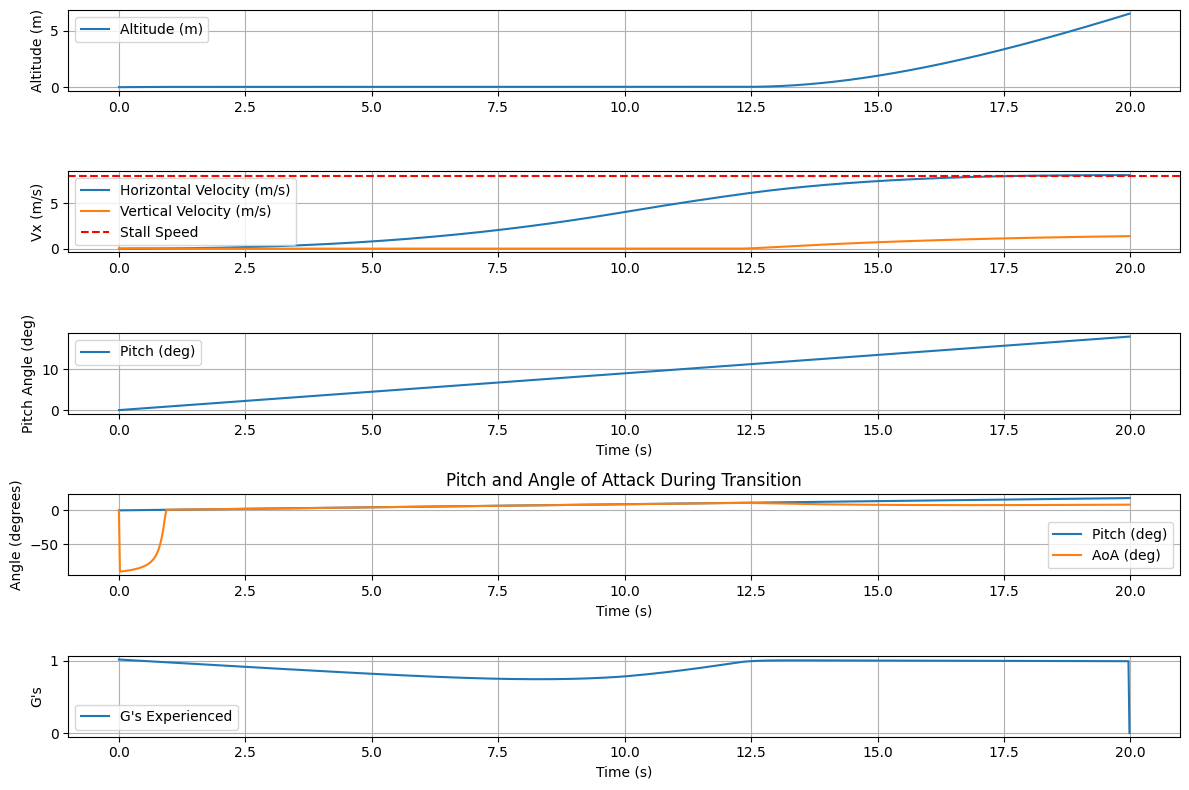

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.interpolate import interp1d

def simulate_transition(
    target_altitude=50,
    thrust_profile_nodes=[(0, 0, 100), (10, 20, 60), (30, 30, 0)],
    max_pitch_deg=18,
    T_end=20
):
    g = 9.81
    rho = 1.225

    mass = 10.0
    wing_area = 1.5
    CL0 = 0.2
    CL_alpha = 5.7
    CD0 = 0.02
    k = 0.04
    stall_speed = 8.0
    eta = 0.7

    rotor_area = 0.2
    dt = 0.02
    time = np.arange(0, T_end, dt)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    x = np.zeros_like(time)
    ngsy = np.zeros_like(time)

    t_nodes = [n[0] for n in thrust_profile_nodes]
    h_nodes = [n[1] for n in thrust_profile_nodes]
    v_nodes = [n[2] for n in thrust_profile_nodes]

    h_interp = interp1d(t_nodes, h_nodes, kind='linear', fill_value='extrapolate')
    v_interp = interp1d(t_nodes, v_nodes, kind='linear', fill_value='extrapolate')

    horizontal_thrust = h_interp(time)
    vertical_thrust = v_interp(time)

    energy_vertical = 0.0
    energy_horizontal = 0.0

    reached_target_altitude = False

    for i in range(1, len(time)):
        if not reached_target_altitude and alt[i-1] >= target_altitude:
            reached_target_altitude = True
            vertical_thrust[i:] = 0  # Cut vertical thrust after target altitude

        if reached_target_altitude and abs(vz[i-1]) < 0.1:
            time = time[:i+1]
            vx = vx[:i+1]
            vz = vz[:i+1]
            alt = alt[:i+1]
            x = x[:i+1]
            pitch = pitch[:i+1]
            ngsy = ngsy[:i+1]
            horizontal_thrust = horizontal_thrust[:i+1]
            vertical_thrust = vertical_thrust[:i+1]
            break

        flight_path_angle = np.arctan2(vz[i-1], vx[i-1] + 1e-4)
        alpha = np.clip(pitch[i] - flight_path_angle, np.deg2rad(-5), np.deg2rad(15))

        CL = CL0 + CL_alpha * alpha
        CD = CD0 + k * CL**2

        speed = np.sqrt(vx[i-1]**2 + vz[i-1]**2)
        lift = 0.5 * rho * speed**2 * wing_area * CL
        drag = 0.5 * rho * speed**2 * wing_area * CD

        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]

        ngsy[i-1] = (lift * np.cos(alpha) - drag * np.sin(alpha) + Tv) / (mass * g * np.cos(pitch[i]))

        Fx = -Tv * np.sin(pitch[i]) + Th * np.cos(pitch[i]) - drag * np.cos(flight_path_angle) - lift * np.sin(flight_path_angle)
        Fz = Th * np.sin(pitch[i]) + Tv * np.cos(pitch[i]) - mass * g + lift * np.cos(flight_path_angle) - drag * np.sin(flight_path_angle)

        az = Fz / mass
        vz[i] = max(vz[i-1] + az * dt, 0)
        alt[i] = max(alt[i-1] + vz[i] * dt, 0)

        ax = Fx / mass
        vx[i] = vx[i-1] + ax * dt
        x[i] = x[i-1] + vx[i] * dt

        max_speed = 18
        vx[i] = np.clip(vx[i], -max_speed, max_speed)
        vz[i] = np.clip(vz[i], -max_speed, max_speed)

        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            P_vert = (Tv * v_induced) / eta
        else:
            P_vert = 0

        v_eff_horizontal = abs(vx[i])
        P_horiz = (Th * v_eff_horizontal) / eta
        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt

    E_total = energy_vertical + energy_horizontal
    P_hover = thrust_profile_nodes[0][2] * np.sqrt(thrust_profile_nodes[0][2] / (2 * rho * rotor_area)) / eta

    print(f"Hover Power: {P_hover:.2f} W")
    print(f"Energy consumption hover: {P_hover * 20 / 1000:.2f} kJ")
    print(f"\n🔋 Estimated Energy Consumption:")
    print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
    print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
    print(f" - Total Energy: {E_total / 1000:.2f} kJ")

    plt.figure(figsize=(12, 8))

    plt.subplot(5, 1, 1)
    plt.plot(time, alt, label="Altitude (m)")
    plt.ylabel("Altitude (m)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(time, vx, label="Horizontal Velocity (m/s)")
    plt.plot(time, vz, label="Vertical Velocity (m/s)")
    plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
    plt.ylabel("Vx (m/s)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
    plt.ylabel("Pitch Angle (deg)")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(time, np.rad2deg(pitch), label='Pitch (deg)')
    plt.plot(time, np.rad2deg(np.array(pitch) - np.arctan2(vz, vx + 1e-6)), label='AoA (deg)')
    plt.title("Pitch and Angle of Attack During Transition")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.legend()
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(time, ngsy, label="G's Experienced")
    plt.ylabel("G's")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call to test interactively
simulate_transition()

6 nodes with interpolation between


🔋 Estimated Energy Consumption:
 - Vertical System: 11.9120 kJ
 - Horizontal System: 10.4660 kJ
 - Total Energy: 22.38 kJ


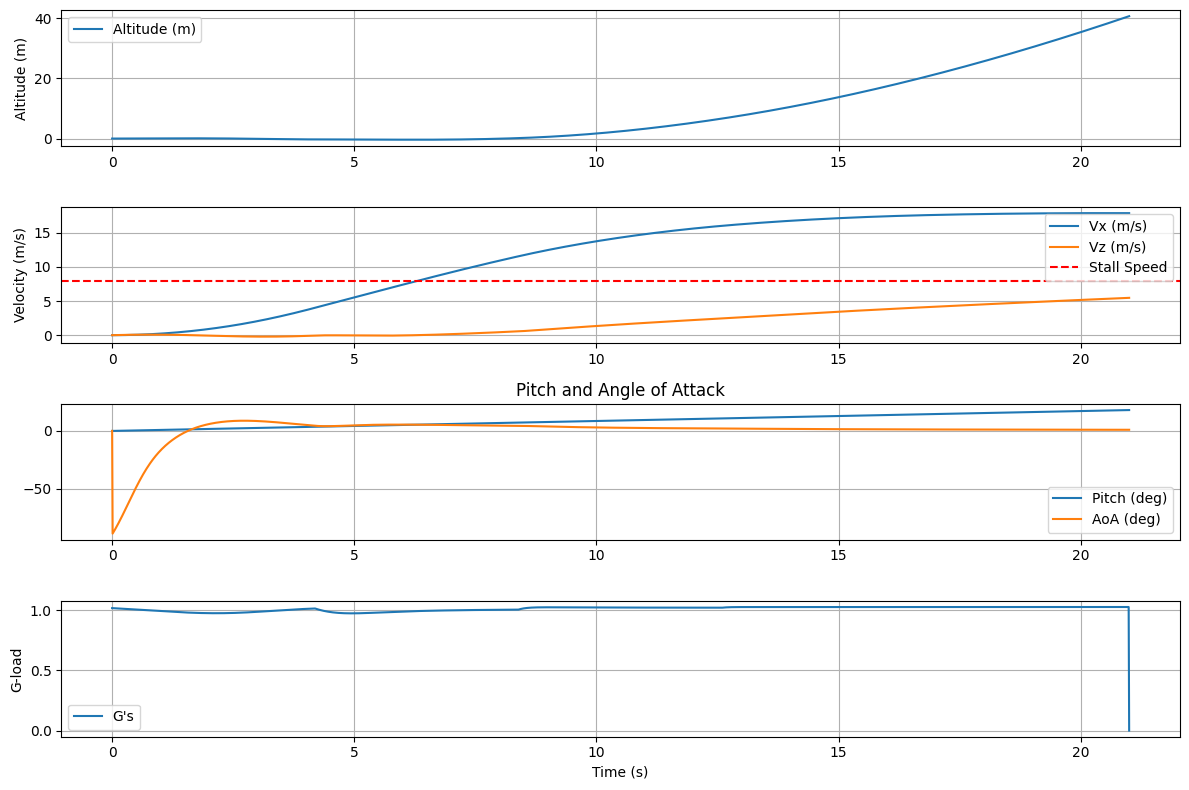

22377.971906450366

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Simulation with thrusts as inputs (for optimization)
def simulate_transition(
    thrusts,
    target_altitude=40,
    max_pitch_deg=18,
    T_end=20,
    dt=0.01,
    return_all=False,
    silent=False
):
    g = 9.81
    rho = 1.225
    mass = 10.0
    wing_area = 1.5
    CL0 = 0.2
    CL_alpha = 5.7
    CD0 = 0.02
    k = 0.04
    stall_speed = 8.0
    eta = 0.7
    rotor_area = 0.2

    time = np.arange(0, T_end + dt, dt)
    node_times = np.linspace(0, T_end, 6)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    x = np.zeros_like(time)
    ngsy = np.zeros_like(time)

    h_nodes = thrusts[:6]
    v_nodes = thrusts[6:]

    h_interp = interp1d(node_times, h_nodes, kind='linear', fill_value='extrapolate')
    v_interp = interp1d(node_times, v_nodes, kind='linear', fill_value='extrapolate')

    horizontal_thrust = h_interp(time)
    vertical_thrust = v_interp(time)

    energy_vertical = 0.0
    energy_horizontal = 0.0

    reached_target_altitude = False
    max_speed = 18
    constraint_violations = []

    for i in range(1, len(time)):
        if not reached_target_altitude and alt[i - 1] >= target_altitude:
            reached_target_altitude = True
            vertical_thrust[i:] = 0

        if reached_target_altitude and abs(vz[i - 1]) < 0.1:
            time = time[:i + 1]
            vx = vx[:i + 1]
            vz = vz[:i + 1]
            alt = alt[:i + 1]
            x = x[:i + 1]
            pitch = pitch[:i + 1]
            ngsy = ngsy[:i + 1]
            horizontal_thrust = horizontal_thrust[:i + 1]
            vertical_thrust = vertical_thrust[:i + 1]
            break

        flight_path_angle = np.arctan2(vz[i - 1], vx[i - 1] + 1e-4)
        alpha = np.clip(pitch[i] - flight_path_angle, np.deg2rad(-5), np.deg2rad(15))

        CL = CL0 + CL_alpha * alpha
        CD = CD0 + k * CL**2

        speed = np.sqrt(vx[i - 1]**2 + vz[i - 1]**2)
        lift = 0.5 * rho * speed**2 * wing_area * CL
        drag = 0.5 * rho * speed**2 * wing_area * CD

        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]

        ngsy[i - 1] = (lift * np.cos(alpha) - drag * np.sin(alpha) + Tv) / (mass * g * np.cos(pitch[i]))

        Fx = -Tv * np.sin(pitch[i]) + Th * np.cos(pitch[i]) - drag * np.cos(flight_path_angle) - lift * np.sin(flight_path_angle)
        Fz = Th * np.sin(pitch[i]) + Tv * np.cos(pitch[i]) - mass * g + lift * np.cos(flight_path_angle) - drag * np.sin(flight_path_angle)

        az = Fz / mass
        vz[i] = vz[i - 1] + az * dt
        alt[i] = alt[i - 1] + vz[i] * dt

        ax = Fx / mass
        vx[i] = vx[i - 1] + ax * dt
        x[i] = x[i - 1] + vx[i] * dt

        if vz[i] < -0.01:
            constraint_violations.append(('vz_neg', time[i]))
        if vx[i] > max_speed:
            constraint_violations.append(('vx_exceed', time[i]))

        vx[i] = np.clip(vx[i], -max_speed, max_speed)
        vz[i] = np.clip(vz[i], -max_speed, max_speed)

        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            P_vert = (Tv * v_induced) / eta
        else:
            P_vert = 0

        v_eff_horizontal = abs(vx[i])
        P_horiz = (Th * v_eff_horizontal) / eta

        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt

    E_total = energy_vertical + energy_horizontal

    if not silent:
        print(f"\n🔋 Estimated Energy Consumption:")
        print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
        print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
        print(f" - Total Energy: {E_total / 1000:.2f} kJ")

        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(time, alt, label="Altitude (m)")
        plt.ylabel("Altitude (m)")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(time, vx, label="Vx (m/s)")
        plt.plot(time, vz, label="Vz (m/s)")
        plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
        plt.ylabel("Velocity (m/s)")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
        plt.plot(time, np.rad2deg(pitch - np.arctan2(vz, vx + 1e-6)), label="AoA (deg)")
        plt.title("Pitch and Angle of Attack")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(time, ngsy, label="G's")
        plt.xlabel("Time (s)")
        plt.ylabel("G-load")
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    if return_all:
        return {
            'E_total': E_total,
            'alt': alt,
            'vx': vx,
            'vz': vz,
            'constraint_violations': constraint_violations,
            'time': time
        }
    else:
        return E_total

# Test call with current profile as input
initial_thrusts = [0, 25, 27, 28, 32, 37, 100, 90, 20, 0, 0, 0]
simulate_transition(initial_thrusts, silent=False, T_end=21)



✅ Optimization completed
Optimal energy: 26811.793929331423 kJ

🔋 Estimated Energy Consumption:
 - Vertical System: 8.9388 kJ
 - Horizontal System: 2.8551 kJ
 - Total Energy: 11.79 kJ


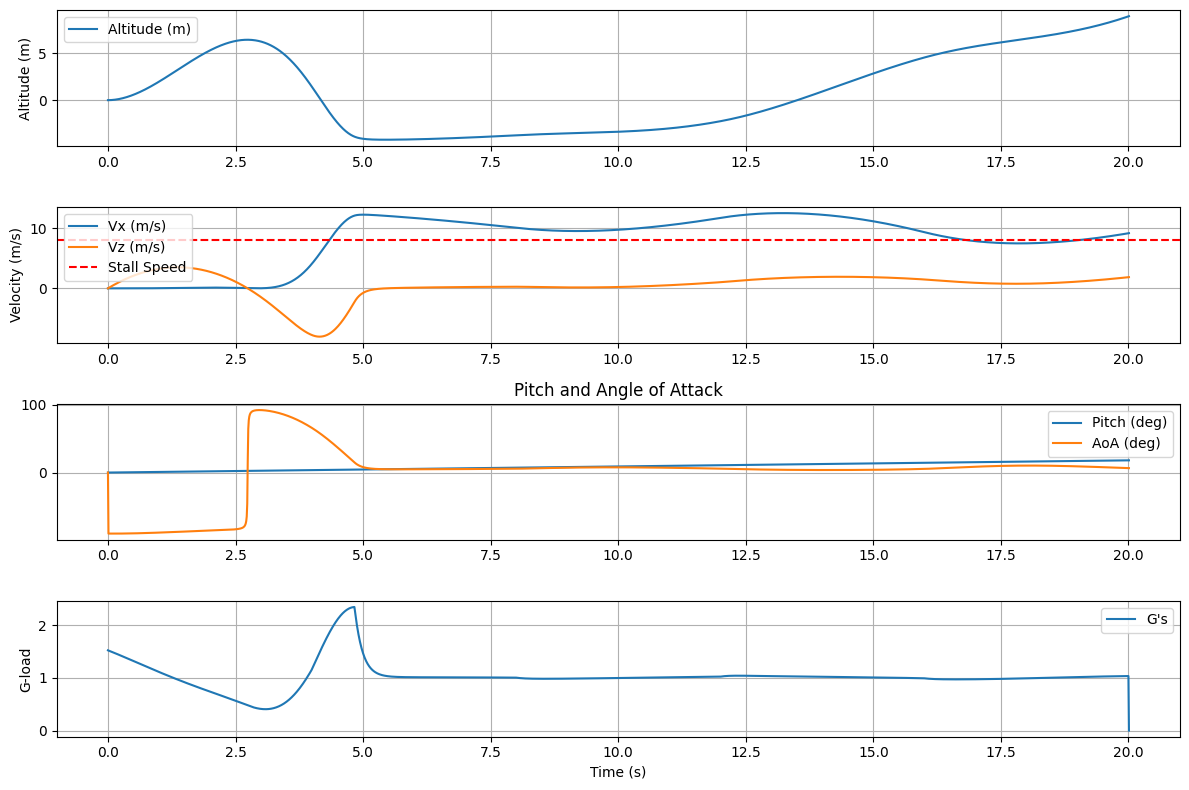

Optimized thrusts: [1.92801582e-02 2.13091512e-01 8.30825957e-03 2.85861826e+01
 2.61372632e-02 4.29253853e+01 1.49744426e+02 1.57128195e-04
 2.67469275e+01 3.34533895e-02 3.37977239e+01 2.85824077e+01]
Optimized energy consumption: 26811.793929331423 kJ


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# Simulation with thrusts as inputs (for optimization)
def simulate_transition(
    thrusts,
    target_altitude=50,
    max_pitch_deg=18,
    T_end=20,
    dt=0.01,
    return_all=False,
    silent=False
):
    g = 9.81
    rho = 1.225
    mass = 10.0
    wing_area = 1.5
    CL0 = 0.2
    CL_alpha = 5.7
    CD0 = 0.02
    k = 0.04
    stall_speed = 8.0
    eta = 0.7
    rotor_area = 0.2

    time = np.arange(0, T_end + dt, dt)
    node_times = np.linspace(0, T_end, 6)

    vx = np.zeros_like(time)
    vz = np.zeros_like(time)
    alt = np.zeros_like(time)
    pitch = np.clip(np.linspace(0, np.deg2rad(max_pitch_deg), len(time)), 0, np.deg2rad(max_pitch_deg))
    x = np.zeros_like(time)
    ngsy = np.zeros_like(time)

    h_nodes = thrusts[:6]
    v_nodes = thrusts[6:]

    h_interp = interp1d(node_times, h_nodes, kind='linear', fill_value='extrapolate')
    v_interp = interp1d(node_times, v_nodes, kind='linear', fill_value='extrapolate')

    horizontal_thrust = h_interp(time)
    vertical_thrust = v_interp(time)

    energy_vertical = 0.0
    energy_horizontal = 0.0

    reached_target_altitude = False
    max_speed = 18
    constraint_violations = []

    for i in range(1, len(time)):
        if not reached_target_altitude and alt[i - 1] >= target_altitude:
            reached_target_altitude = True
            vertical_thrust[i:] = 0

        if reached_target_altitude and abs(vz[i - 1]) < 0.1:
            time = time[:i + 1]
            vx = vx[:i + 1]
            vz = vz[:i + 1]
            alt = alt[:i + 1]
            x = x[:i + 1]
            pitch = pitch[:i + 1]
            ngsy = ngsy[:i + 1]
            horizontal_thrust = horizontal_thrust[:i + 1]
            vertical_thrust = vertical_thrust[:i + 1]
            break

        flight_path_angle = np.arctan2(vz[i - 1], vx[i - 1] + 1e-4)
        alpha = np.clip(pitch[i] - flight_path_angle, np.deg2rad(-5), np.deg2rad(15))

        CL = CL0 + CL_alpha * alpha
        CD = CD0 + k * CL**2

        speed = np.sqrt(vx[i - 1]**2 + vz[i - 1]**2)
        lift = 0.5 * rho * speed**2 * wing_area * CL
        drag = 0.5 * rho * speed**2 * wing_area * CD

        Tv = vertical_thrust[i]
        Th = horizontal_thrust[i]

        ngsy[i - 1] = (lift * np.cos(alpha) - drag * np.sin(alpha) + Tv) / (mass * g * np.cos(pitch[i]))

        Fx = -Tv * np.sin(pitch[i]) + Th * np.cos(pitch[i]) - drag * np.cos(flight_path_angle) - lift * np.sin(flight_path_angle)
        Fz = Th * np.sin(pitch[i]) + Tv * np.cos(pitch[i]) - mass * g + lift * np.cos(flight_path_angle) - drag * np.sin(flight_path_angle)

        az = Fz / mass
        vz[i] = vz[i - 1] + az * dt
        alt[i] = alt[i - 1] + vz[i] * dt

        ax = Fx / mass
        vx[i] = vx[i - 1] + ax * dt
        x[i] = x[i - 1] + vx[i] * dt

        if vz[i] < -0.01:
            constraint_violations.append(('vz_neg', time[i]))
        if vx[i] > max_speed:
            constraint_violations.append(('vx_exceed', time[i]))

        vx[i] = np.clip(vx[i], -max_speed, max_speed)
        vz[i] = np.clip(vz[i], -max_speed, max_speed)

        if Tv > 0:
            v_induced = np.sqrt(Tv / (2 * rho * rotor_area))
            P_vert = (Tv * v_induced) / eta
        else:
            P_vert = 0

        v_eff_horizontal = abs(vx[i])
        P_horiz = (Th * v_eff_horizontal) / eta

        energy_vertical += P_vert * dt
        energy_horizontal += P_horiz * dt

    E_total = energy_vertical + energy_horizontal

    if not silent:
        print(f"\n🔋 Estimated Energy Consumption:")
        print(f" - Vertical System: {energy_vertical / 1000:.4f} kJ")
        print(f" - Horizontal System: {energy_horizontal / 1000:.4f} kJ")
        print(f" - Total Energy: {E_total / 1000:.2f} kJ")

        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(time, alt, label="Altitude (m)")
        plt.ylabel("Altitude (m)")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(time, vx, label="Vx (m/s)")
        plt.plot(time, vz, label="Vz (m/s)")
        plt.axhline(stall_speed, color='r', linestyle='--', label="Stall Speed")
        plt.ylabel("Velocity (m/s)")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(time, np.rad2deg(pitch), label="Pitch (deg)")
        plt.plot(time, np.rad2deg(pitch - np.arctan2(vz, vx + 1e-6)), label="AoA (deg)")
        plt.title("Pitch and Angle of Attack")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(time, ngsy, label="G's")
        plt.xlabel("Time (s)")
        plt.ylabel("G-load")
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    if return_all:
        return {
            'E_total': E_total,
            'alt': alt,
            'vx': vx,
            'vz': vz,
            'constraint_violations': constraint_violations,
            'time': time
        }
    else:
        return E_total

def optimize_transition(initial_guess):
    bounds = [(0, 150)] * 12

    def objective(thrusts):
        result = simulate_transition(thrusts, silent=True, return_all=True)
        penalty = 0
        for v in result['constraint_violations']:
            if v[0] == 'vz_neg':
                penalty += 1e5
            elif v[0] == 'vx_exceed':
                penalty += 1e5
        return result['E_total'] + penalty

    result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')
    print("\n✅ Optimization completed")
    print("Optimal energy:", result.fun / 1000, "kJ")
    simulate_transition(result.x)
    return result

# Test call with current profile as input
initial_thrusts = [0, 40, 80, 80, 40, 0, 120, 100, 80, 60, 30, 0]
result = optimize_transition(initial_thrusts)
print("Optimized thrusts:", result.x)
print("Optimized energy consumption:", result.fun / 1000, "kJ")
# E_total = simulate_transition(result.x, silent=True, return_all=True)['E_total']